# Data

In [ ]:
from utils import *
config = load_config("config.yaml")

# read all data sources, union into one long pd dataframe
temp = load_tables(config['data_path'])
df = merge_dfs(temp)
data = pick_from_list_str(df, config['output_cols'], index=config['segment'])

# convert all string to float
data = convert_strings_to_float(data)

# to log scale
data = log_scale_df(data, config['log_cols'])

# remove outliers (thresholding percentile)
# data = add_valid_flag(data, config['longtail_cols'], config['outlier_threshold'])
# data = data[data['valid'] == 1].drop(columns=['valid']).reset_index(drop=True)

# normalized range
data = normalize_min_max(data, config['output_cols']+config['input_cols'])
data

# Training

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
config = load_config("config.yaml")

# ——— Model ———
def build_model(config):
    inp = tf.keras.Input(shape=(len(config['input_cols']),))
    
    x = tf.keras.layers.Dense(256, use_bias=False)(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Dense(128, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Dense(128, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Dense(32, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # linear output for full-range regression
    out = tf.keras.layers.Dense(len(config['target_cols']))(x)
    
    opt = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.Huber(),
        # loss='mse',
        metrics=['mae']
    )
    return model

model = build_model(config)
model.summary()

In [ ]:
# ——— Data prep ———
X = data[config['input_cols']].to_numpy(dtype='float32')
y = data[config['target_cols']].to_numpy(dtype='float32')

n = X.shape[0]
idx = tf.random.shuffle(tf.range(n), seed=config['seed'])
n_test = int(config['test_size'] * n)
n_val  = int(config['val_size']  * n)

test_idx  = idx[:n_test]
val_idx   = idx[n_test:n_test+n_val]
train_idx = idx[n_test+n_val:]

def make_ds(indices):
    return (tf.data.Dataset
              .from_tensor_slices((tf.gather(X, indices),
                                   tf.gather(y, indices)))
              .batch(config['batch_size'])
              .prefetch(tf.data.AUTOTUNE))

train_ds, val_ds, test_ds = map(make_ds, (train_idx, val_idx, test_idx))


# ——— Callbacks ———
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=config['patience'],
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=config['model_path'],
        monitor='val_loss',
        save_best_only=True
    )
]

# ——— Train ———
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config['epochs'],
    callbacks=callbacks,
    verbose=1
)
model.save(config['model_path'])
plot_history(history)

# ——— Eval ———
X_test = np.vstack([x for x, _ in test_ds])
y_test = np.vstack([y for _, y in test_ds])

# model predictions
y_pred = model.predict(test_ds)

# build and save dataframe
df_out = pd.DataFrame(
    np.hstack([X_test, y_test, y_pred]),
    columns=(
        config['input_cols']
      + [f"true_{c}" for c in config['target_cols']]
      + [f"pred_{c}" for c in config['target_cols']]
    )
)
df_out.to_csv(config['save_to'] + "test_results.csv", index=False)

## Training with different dataset size

In [ ]:
# ——— Data prep ———
X_full = data[config['input_cols']].to_numpy(dtype='float32')
y_full = data[config['target_cols']].to_numpy(dtype='float32')
n_full = X_full.shape[0]

# ——— fixed helpers ———
def make_ds(X, y, indices):
    return (tf.data.Dataset
              .from_tensor_slices((tf.gather(X, indices),
                                   tf.gather(y, indices)))
              .batch(config['batch_size'])
              .prefetch(tf.data.AUTOTUNE))

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=config['patience'],
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=config['model_path'],
        monitor='val_loss',
        save_best_only=True
    )
]

# ——— subsample loop ———
final_results = []
for p in range(100, 0, -5):                # 100, 95, …, 5%
    m = int(n_full * p / 100)             # samples to use
    sub_idx = tf.random.shuffle(tf.range(n_full), seed=config['seed'])[:m]
    X, y = tf.gather(X_full, sub_idx), tf.gather(y_full, sub_idx)

    # shuffle & split
    n = m
    idx = tf.random.shuffle(tf.range(n), seed=config['seed'])
    n_test = int(config['test_size'] * n)
    n_val  = int(config['val_size']  * n)

    test_idx  = idx[:n_test]
    val_idx   = idx[n_test:n_test+n_val]
    train_idx = idx[n_test+n_val:]

    train_ds = make_ds(X, y, train_idx)
    val_ds   = make_ds(X, y, val_idx)
    test_ds  = make_ds(X, y, test_idx)

    # train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=config['epochs'],
        callbacks=callbacks,
        verbose=1
    )
    plot_history(history)

    # eval
    X_test = np.vstack([x for x, _ in test_ds])
    y_test = np.vstack([y for _, y in test_ds])
    y_pred = model.predict(test_ds)

    # save with sample size in filename
    df_out = pd.DataFrame(
        np.hstack([X_test, y_test, y_pred]),
        columns=(
            config['input_cols']
          + [f"true_{c}" for c in config['target_cols']]
          + [f"pred_{c}" for c in config['target_cols']]
        )
    )
    out_path = f"{config['save_to']}test_results_{m}.csv"
    df_out.to_csv(out_path, index=False)
    print(f"p={p}% ({m} samples) → saved to {out_path}")
    
    dic = metrics(y_test.mean(axis=1),y_pred.mean(axis=1))
    final_results.append(merge_dicts(dic, {"sample_number": m}))

    model = build_model(config)

def convert(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    return obj

# Recursively process the list of dicts
cleaned_data = [{k: convert(v) for k, v in d.items()} for d in final_results]

with open("results/sample_efficiency.json", "w") as f:
    json.dump(cleaned_data, f)

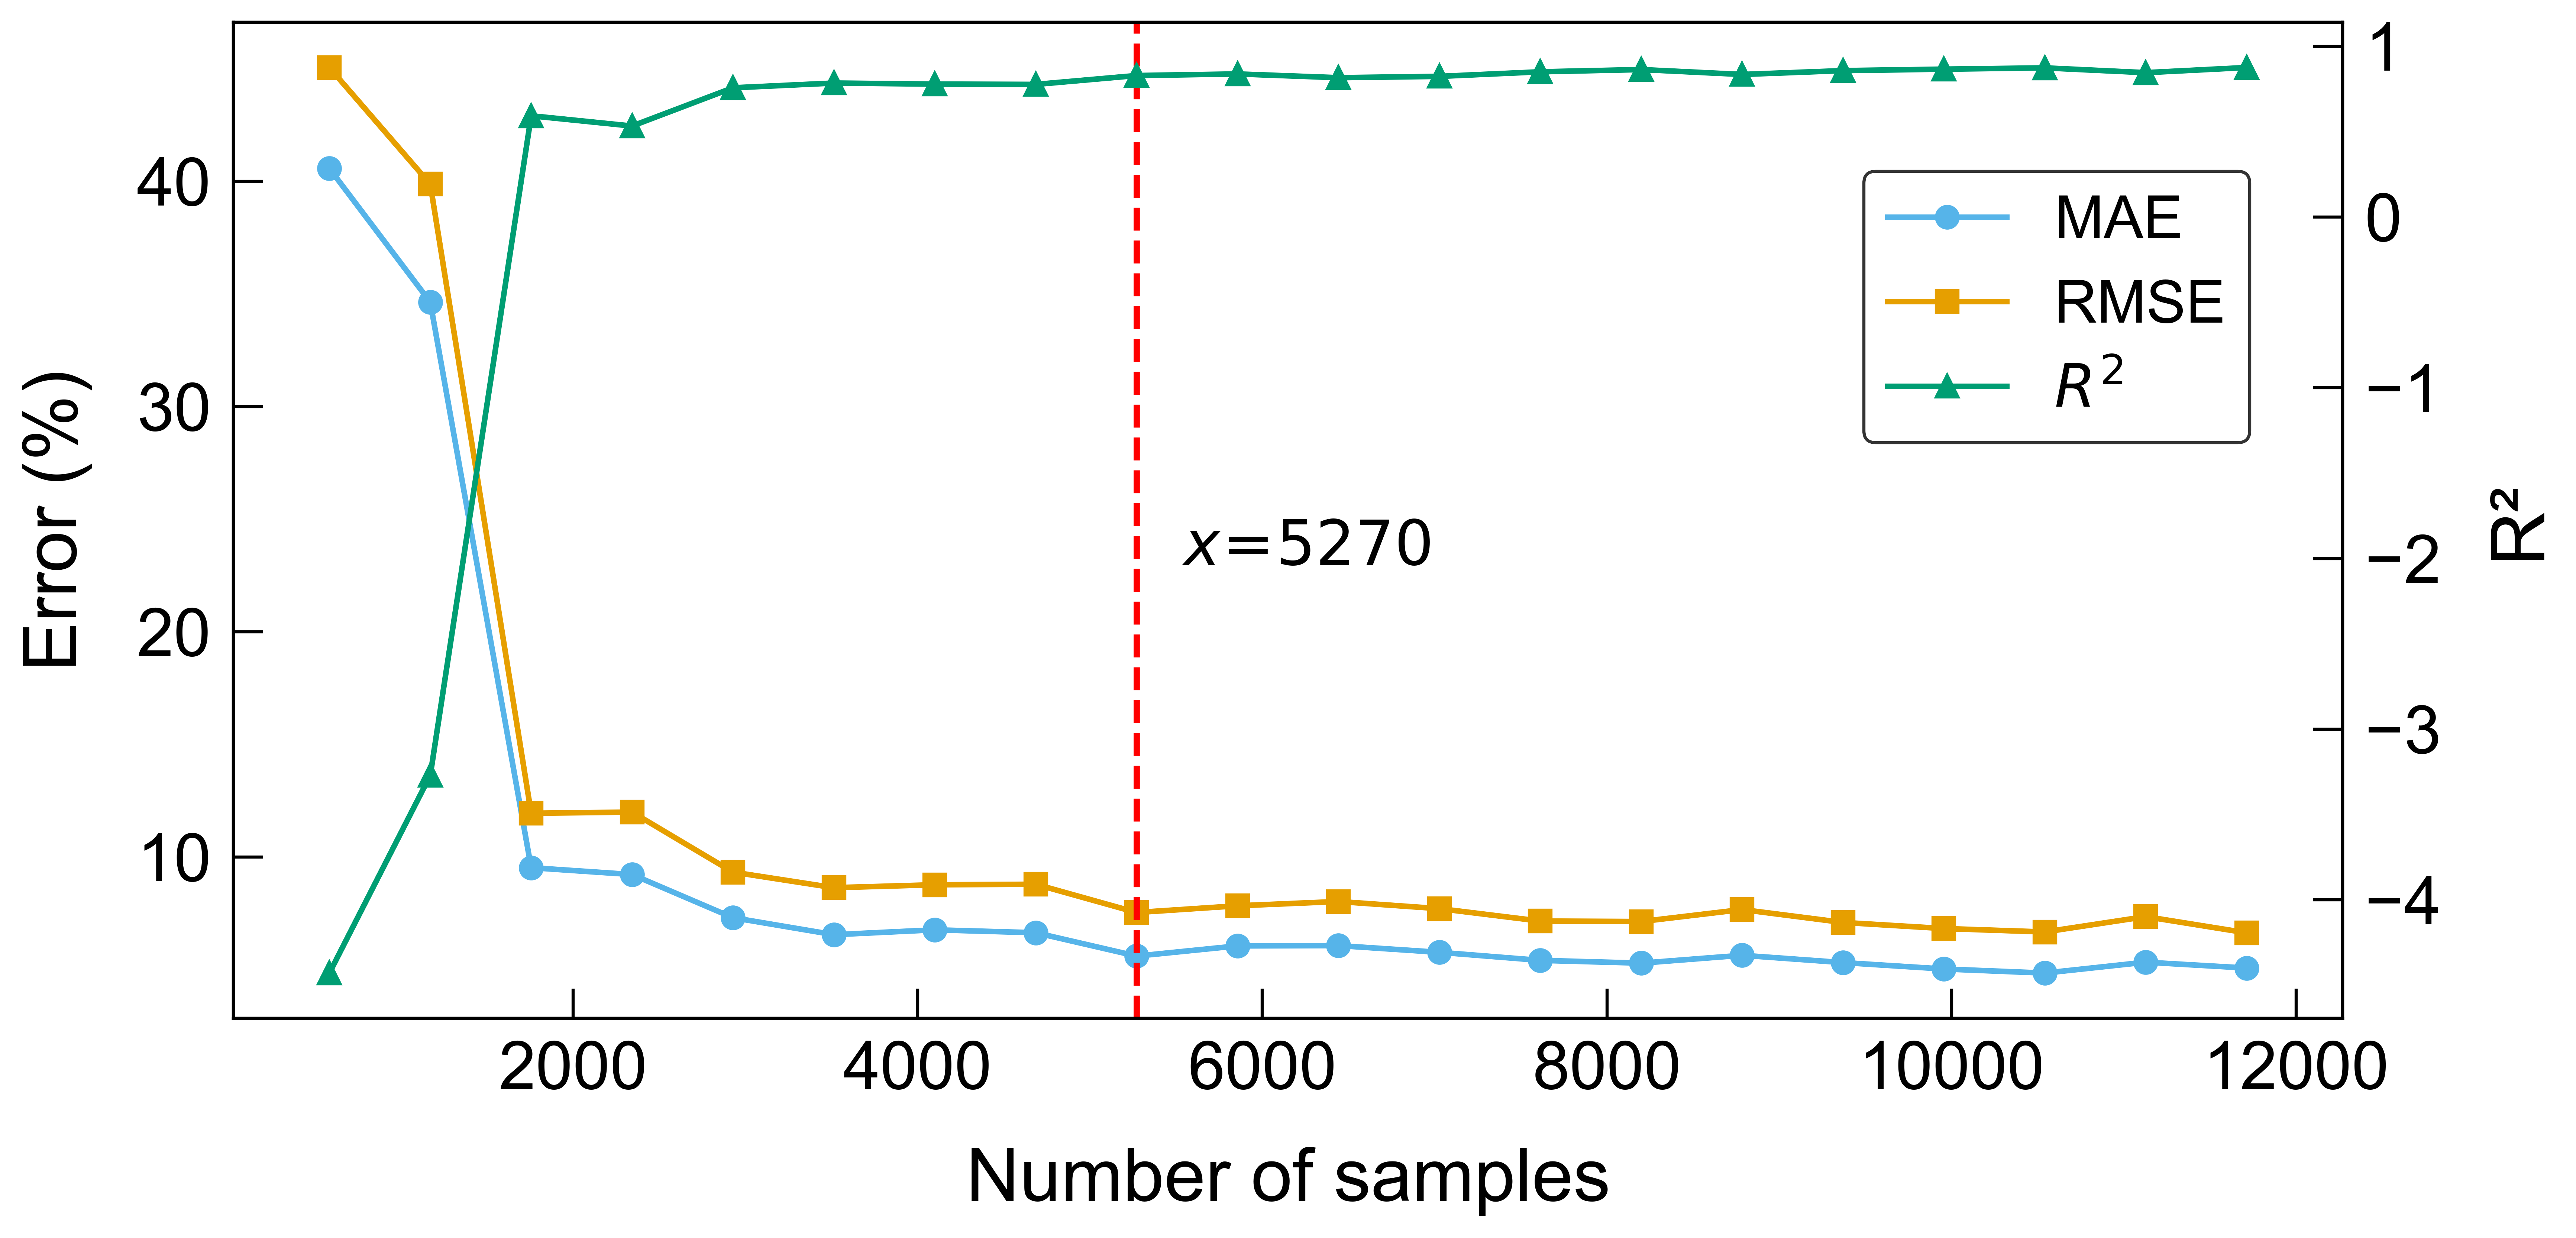

In [19]:
import matplotlib.pyplot as plt
import json
from APS_PLOT_STYLE import *

set_aps_single_column(scale=2.4)


# APS-style colors
COLORS = {
    'MAE': '#56B4E9',   # sky blue
    'RMSE': '#E69F00',  # orange
    'R2': '#009E73',    # bluish green
}


def plot_key_lines(data_list, y_keys, x_key, margin_frac=0.05):
    # sort by x
    sorted_data = sorted(data_list, key=lambda d: d[x_key])
    # scale x by 0.8
    x = [d[x_key] * 0.8 for d in sorted_data]

    # which keys go where
    left_keys  = [k for k in ['MAE', 'RMSE'] if k in y_keys]
    right_keys = [k for k in ['R2']     if k in y_keys]

    # scale left errors to percent immediately
    left_vals  = [[d[k]*100 for d in sorted_data] for k in left_keys]
    right_vals = [[d[k]     for d in sorted_data] for k in right_keys]

    def limits(vals):
        vmin, vmax = min(min(v) for v in vals), max(max(v) for v in vals)
        vr = vmax - vmin
        return vmin - margin_frac*vr, vmax + margin_frac*vr

    left_lim  = limits(left_vals)  if left_vals  else None
    right_lim = limits(right_vals) if right_vals else None

    # make figure larger
    fig, ax_l = plt.subplots(figsize=(12, 6), dpi=600)
    ax_r = ax_l.twinx() if right_lim else None

    markers = ['o', 's']
    # plot left (%)
    for i, k in enumerate(left_keys):
        ax_l.plot(x, left_vals[i],
                  marker=markers[i],
                  markersize=7,
                  label=k,
                  color=COLORS[k])
    if left_lim:
        ax_l.set_ylim(*left_lim)

    # plot right (with math‑style label)
    if ax_r:
        k = right_keys[0]
        ax_r.plot(x, right_vals[0],
                  marker='^',
                  markersize=7,
                  label=r'$R^2$',
                  color=COLORS[k])
        ax_r.set_ylim(*right_lim)

    ax_l.set_xlabel('Number of samples')
    ax_l.set_ylabel('Error (%)')
    if ax_r:
        ax_r.set_ylabel('R²')

    # combined legend
    hl, ll = ax_l.get_legend_handles_labels()
    if ax_r:
        hr, lr = ax_r.get_legend_handles_labels()
        ax_l.legend(hl+hr, ll+lr,
                    loc='upper right',
                    bbox_to_anchor=(0.97, 0.88))
    else:
        ax_l.legend(hl, ll,
                    loc='upper right',
                    bbox_to_anchor=(0.97, 0.88))

    # vertical line at scaled threshold
    raw_thresh = 6588
    thresh = int(raw_thresh * 0.8)
    ax_l.axvline(thresh, color='red', linestyle='--', linewidth=2)

    # compute a 2% offset in data‐coords
    x_off = thresh * 0.05

    # math‑style label for the line
    ax_l.text(
        thresh + x_off,
        0.5,
        rf'$x\!=\!{int(thresh)}$',
        # r'X = 5270',
        transform=ax_l.get_xaxis_transform(),
        ha='left', va='top',
        fontsize=20, 
        color='black'
    )
    
    plt.tight_layout()
    fig.savefig('results/sample_efficiency.pdf', format='pdf', bbox_inches='tight')
    plt.show()

with open("results/sample_efficiency.json", "r") as f:
    final_results = json.load(f)
    
plot_key_lines(final_results, y_keys=["RMSE","MAE","R2"], x_key="sample_number", margin_frac=0.05)

# Evaluation

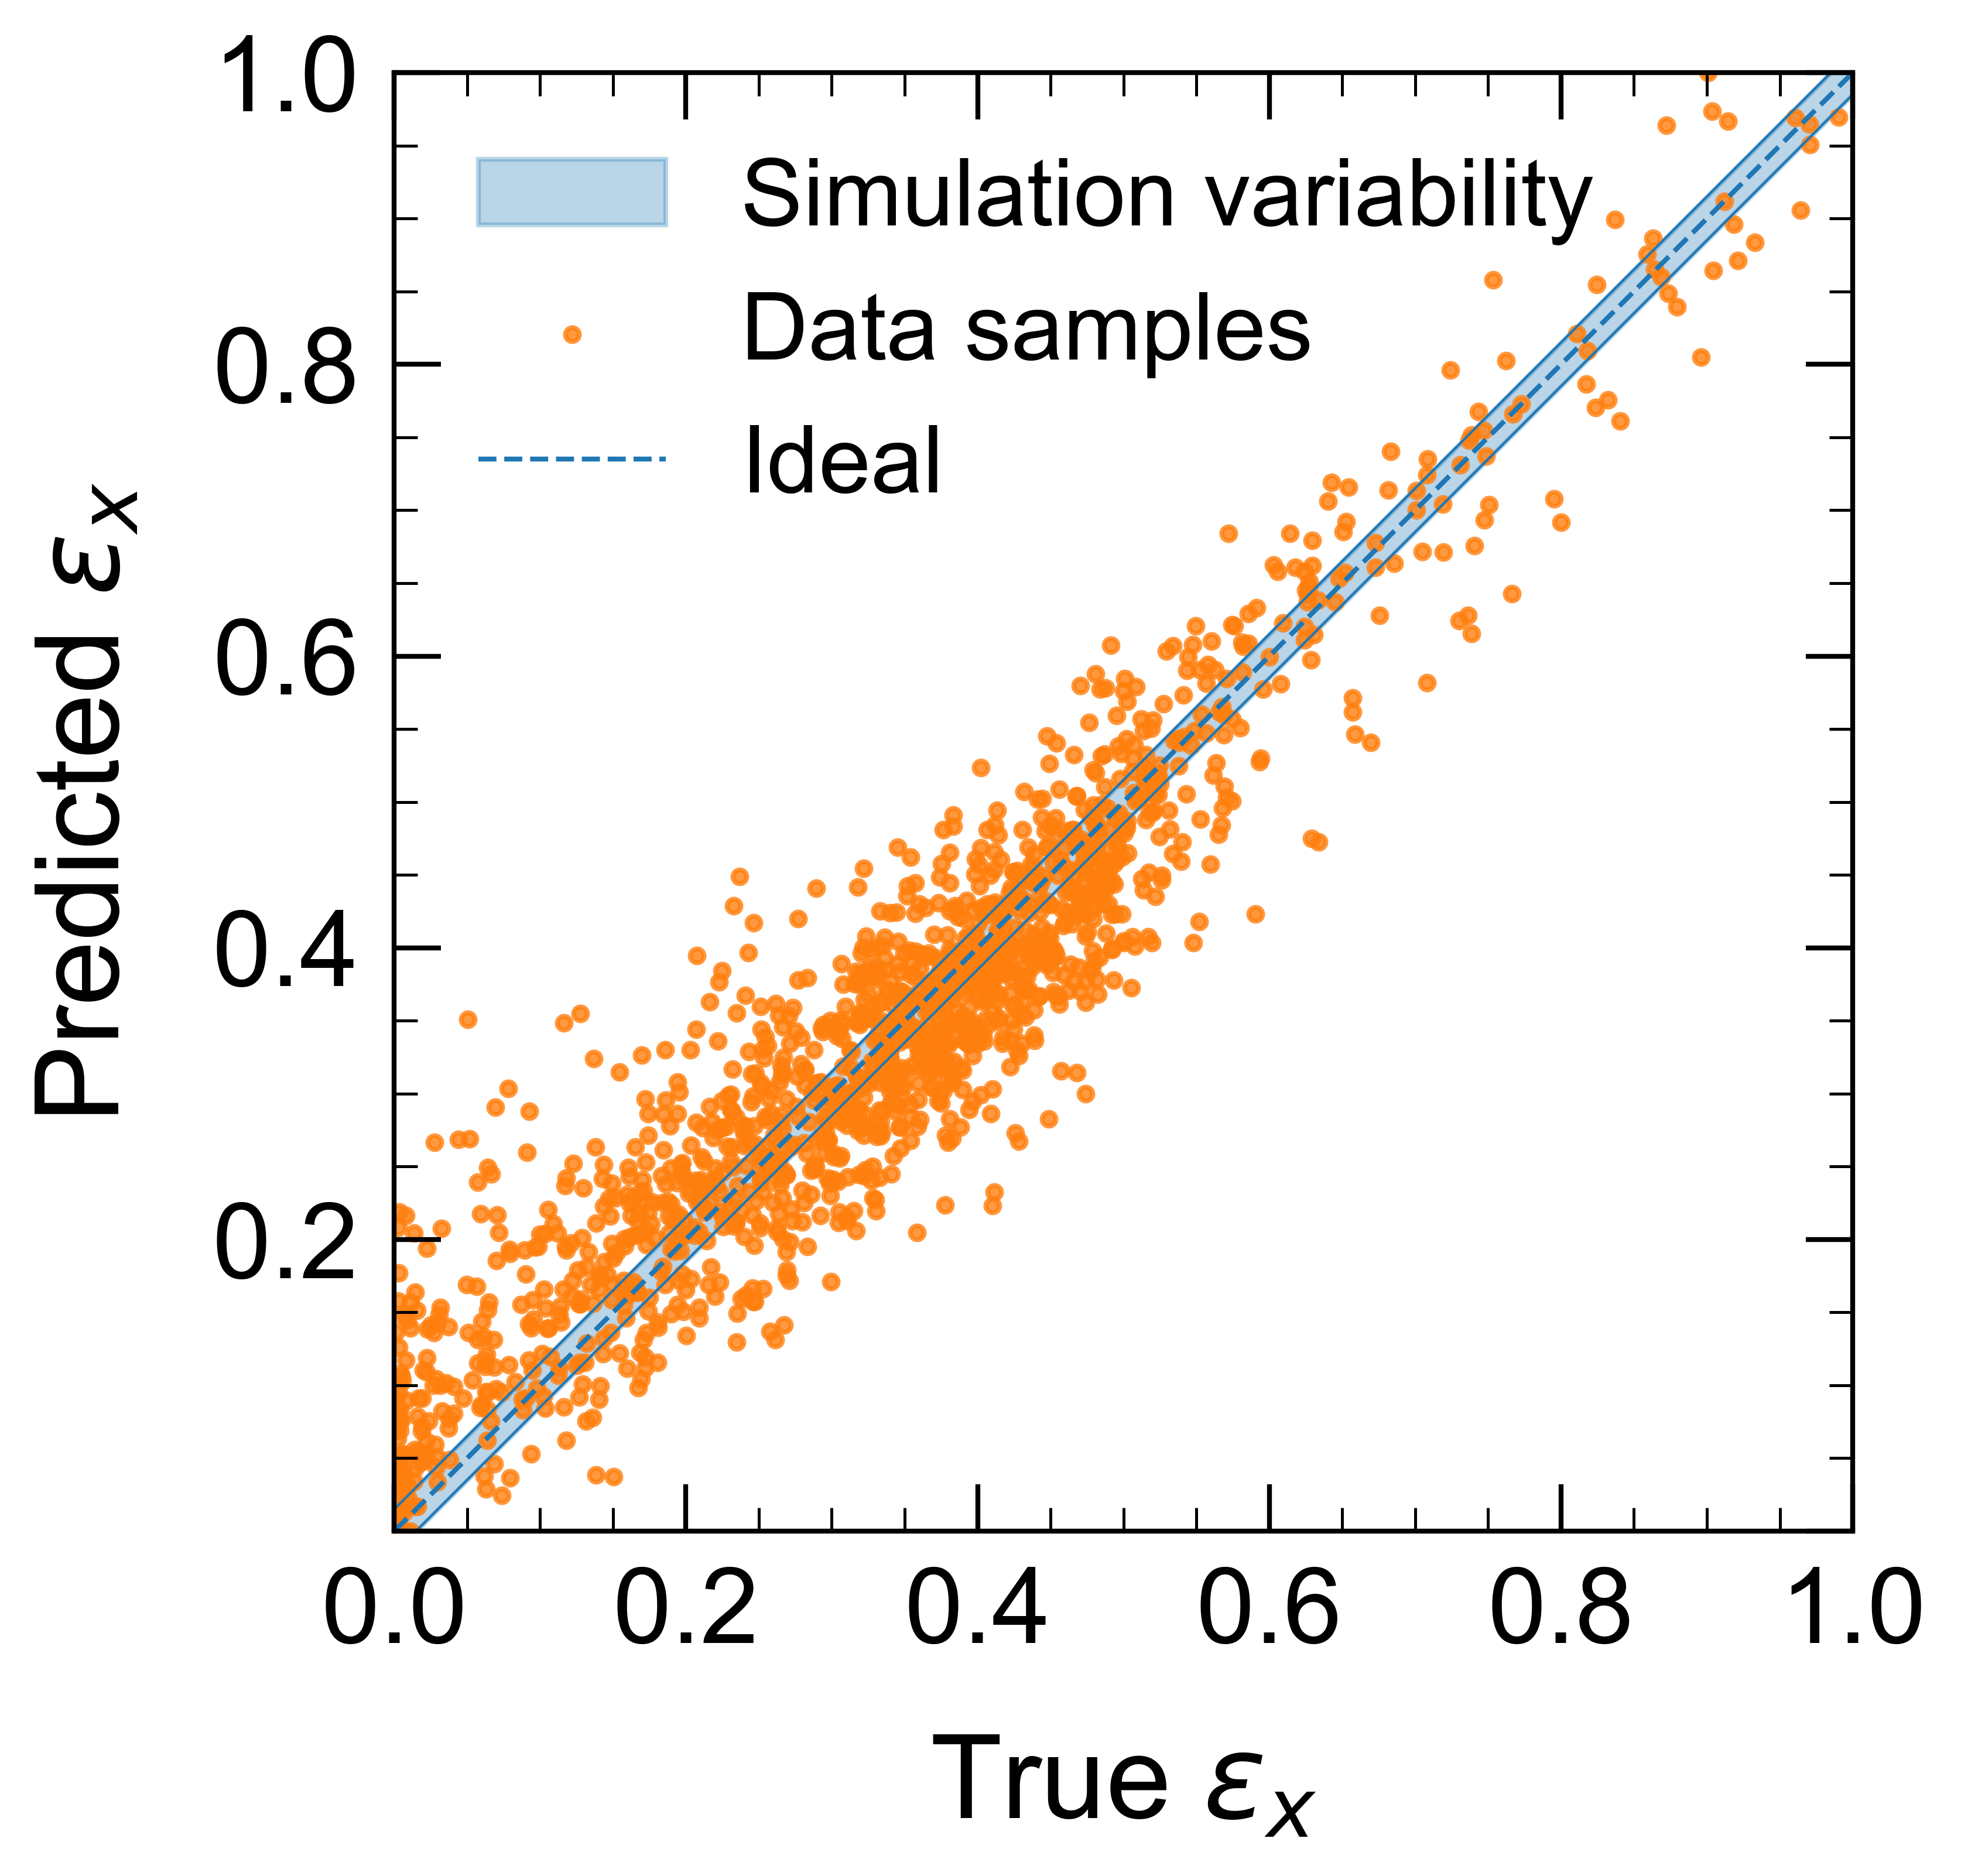

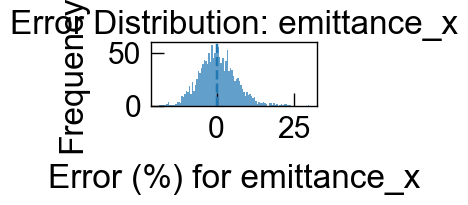

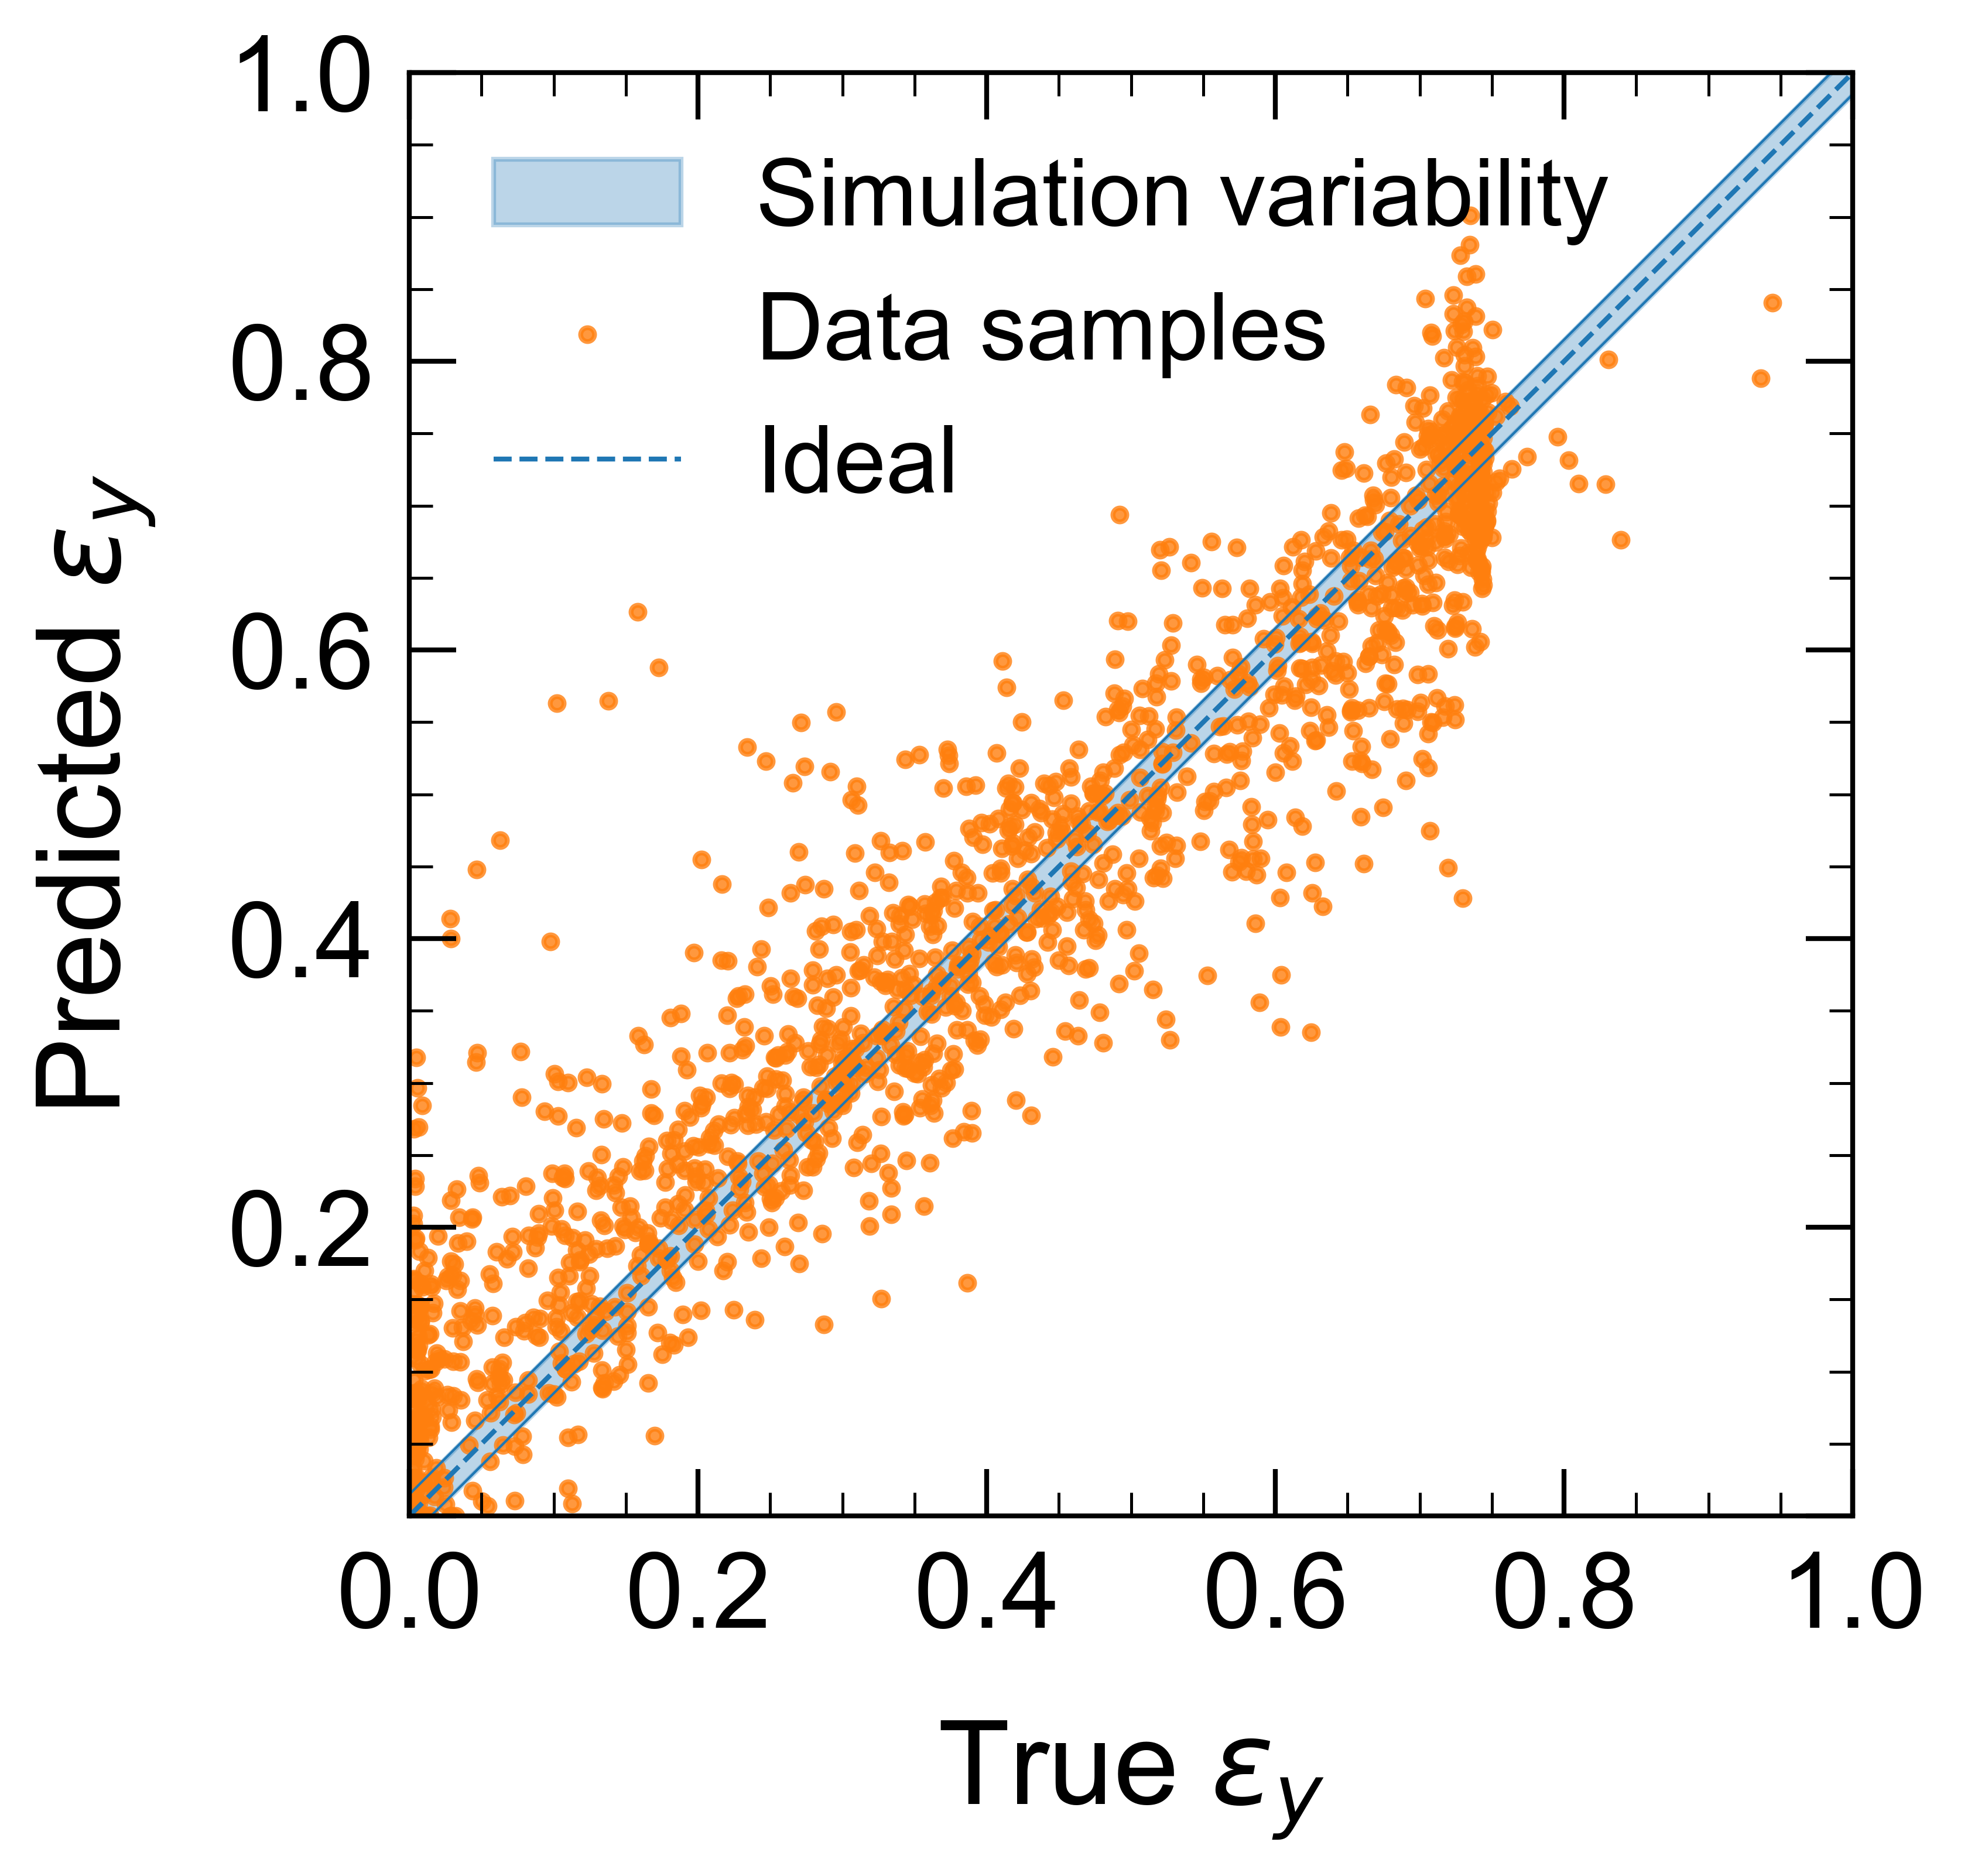

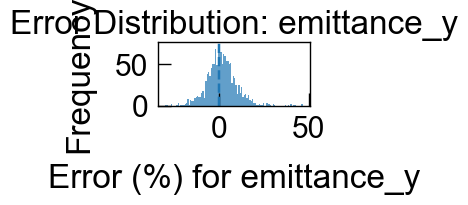

In [13]:
from utils import *
from functools import partial
from APS_PLOT_STYLE import *


set_aps_single_column(scale=2.4)

def plot_true_vs_pred(y_true, y_pred, name, rng):
    # label
    if name in ('emittance_x','emittance_y'):
        var = 'x' if name=='emittance_x' else 'y'
        label_tex = rf'$\varepsilon_{var}$'
    else:
        label_tex = name

    # constant 0–1 range
    x = np.linspace(0, 1, 200)
    blue   = '#1f77b4'
    orange = '#ff7f0e'

    # square figure
    fig, ax = plt.subplots(figsize=(6, 6), dpi=600)

    # ±rng/2 band
    ax.fill_between(x, x - rng/2, x + rng/2,
                    color=blue, alpha=0.3,
                    label='Simulation variability')
    ax.plot(x, x - rng/2, '-', color=blue, linewidth=0.5)
    ax.plot(x, x + rng/2, '-', color=blue, linewidth=0.5)

    # data
    ax.scatter(y_true, y_pred,
               c=orange, alpha=0.8, s=8,
               label='Data samples')

    # perfect‑prediction line
    ax.plot([0, 1], [0, 1], '--', color=blue, linewidth=1,
            label=r'Ideal')
    
    # labels
    ax.set_xlabel(f'True {label_tex}')
    ax.set_ylabel(f'Predicted {label_tex}')

    # fixed axes and square aspect
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', 'box')

    # force ticks at 0.0, 0.2, …, 1.0
    ticks = np.linspace(0, 1, 6)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    # APS‑style one‑decimal formatter
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda v, pos: f'{v:.1f}')
    )
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda v, pos: '' if v == 0 else f'{v:.1f}')
    )

    # Show major ticks on all sides
    ax.tick_params(axis='both', which='major', direction='in', top=True, right=True)
    
    # Show minor ticks on all sides
    ax.tick_params(axis='both', which='minor', direction='in', top=True, right=True)
    
    # Enable minor ticks
    ax.minorticks_on()

    ax.legend(frameon=False, loc='best')
    plt.tight_layout()
    plt.show()


# preset by keyword
# emittance_x 0.03
# emittance_y 0.05
new_func = partial(plot_true_vs_pred, rng=0.03)  # 0.052
funcs = [new_func, plot_error_distribution]

config = load_config("config.yaml")
result = pd.read_csv(config['save_to']+"test_results.csv")
result = clip_df(result)
process_df(result, inputs=config['input_cols'], outputs=config['target_cols'], save_to=config['save_to'], funcs=funcs)

# Exploratory data analysis

In [ ]:
plot_distributions(data, bins=200)

In [ ]:
from utils import *

config = load_config("config.yaml")


temp = []
for i in range(8):
    df = pd.read_csv(config['data_path'])
    data = pick_from_list_str(df, config['output_cols'], index=i)
    data = convert_strings_to_float(data)
    temp.append(data)
min_d, max_d = compute_bounds(temp)

temp = []
for i in range(8):
    df = pd.read_csv(config['data_path'])
    data = pick_from_list_str(df, config['output_cols'], index=i)
    data = convert_strings_to_float(data)
    temp.append(plot_distributions(data, bins=200, min_bounds=min_d, max_bounds=max_d, title=f'segment_{i+1}'))

figures_to_gif(temp, config['save_to'])

## system’s stability 

In [ ]:
from utils import * 
import math
from typing import List

config = load_config("config.yaml")

def std(values: List[float]) -> float:
    """
    Compute the 1σ standard deviation of a list of numbers,
    using N in the denominator (population formula).
    """
    n = len(values)
    if n == 0:
        raise ValueError("Empty list: no values to compute std.")
    mean = sum(values) / n
    variance = sum((x - mean) ** 2 for x in values) / n
    return math.sqrt(variance)

def range_of_list(values):
    """
    Returns max(values) - min(values), or None for an empty list.
    """
    if not values:
        return None
    return max(values) - min(values)

df = pd.read_csv('data/batch_results_2.csv')
data = pick_from_list_str(df, config['output_cols'], index=config['segment'])
data = convert_strings_to_float(data)
data = log_scale_df(data, config['log_cols'])
data = normalize_min_max(data, config['output_cols']+config['input_cols'])

for i in ['emittance_x', 'emittance_y']:
    temp = []
    for j in range(int(df['index'].max())+1):
        sigma = range_of_list(data[data['index'] == j][i].tolist())
        temp.append(sigma)
    print(' '.join([i, str(max(temp))]))